# Description

The following python jupyter notetbook worksheet provide the code used for calculations used in a manuscript titled "Emergent coherent modes in nonlinear magnonic waveguides detected at ultrahigh frequency resolution". Specificially it includes codes for

1. Spin wave dispersion calculation based on B. A. Kalinikos and A. N. Slavin, J. Phys. C: Solid State Phys. 19 7013-7033 (1986)

2. Calculation of magnon pairs based on 4 magnon scattering process described in Eq. (2) in a manuscript titled "Emergent coherent modes in nonlinear magnonic waveguides detected at ultrahigh frequency resolution"

3. CPW Antenna field calculation

# Import

## Python library

In [2]:
# math
import numpy as np
from lmfit.models import LorentzianModel, LinearModel, QuadraticModel, Model
from scipy.signal import savgol_filter
from scipy.integrate import quad, dblquad
from scipy.optimize import fsolve
import scipy
import math
import matplotlib
import random

from matplotlib.cm import ScalarMappable

import pickle
from subprocess import run, PIPE, STDOUT
from tqdm import tqdm
import itertools

# file management
import re
import natsort
import os

# Image loading
from IPython.display import Image

# 3D plot
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

# matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.cm as cmaps
from matplotlib.colors import LightSource
from matplotlib import rc
import matplotlib.pyplot as plt

# image processing
from scipy.ndimage.filters import gaussian_filter
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

def FigForm(fsize):
#     plt.rcParams['text.usetex'] = True
    plt.rcParams['figure.figsize']=[8.*(1+np.sqrt(5.))/2.,8.]
    plt.rcParams['font.size'] = fsize
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['xtick.major.size']=10
    plt.rcParams['ytick.major.size']=10
    plt.rcParams['xtick.minor.size']=5
    plt.rcParams['ytick.minor.size']=5
    plt.rcParams['xtick.direction']='in'
    plt.rcParams['ytick.direction']='in'
    plt.rcParams['grid.color']='lightgrey'
    plt.rcParams['grid.linestyle']='--'
    plt.rcParams['grid.linewidth']=1.
    plt.rcParams['axes.axisbelow'] ='line'
    plt.rcParams['axes.grid'] = False
    return

## Spin wave library

In [3]:
def P(kx,ky,n,L):
    if n==0:
        return 1 - ( 1 - np.e**( -np.sqrt(kx**2+ky**2)*L ) ) / ( np.sqrt(kx**2+ky**2)*L ) 
    else:
        return (kx**2+ky**2)/(kx**2+ky**2+(n*np.pi/L)**2) -\
    2*(kx**2+ky**2)**2*( 1-(-1)**n*np.e**( -np.sqrt(kx**2+ky**2)*L ) )\
    /( (kx**2+ky**2+(n*np.pi/L)**2)**2 * np.sqrt(kx**2+ky**2)*L )
    
def F(kx,ky,n,muM,muH,D,L,theta):
    cosphi2=kx**2/(kx**2+ky**2)
    sinphi2=ky**2/(kx**2+ky**2)
    sintheta2=(np.sin(theta))**2
    costheta2=(np.cos(theta))**2
    
    return sintheta2+P(kx,ky,n,L)*costheta2-P(kx,ky,n,L)*cosphi2*sintheta2\
+sintheta2*P(kx,ky,n,L)*(1-P(kx,ky,n,L))*muM /(muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*sinphi2

def KS_Freq(g,kx,ky,n,muM,muH,D,L,theta):
    return g*np.sqrt( (muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*\
                  (muH+D*(kx**2+ky**2+(n*np.pi/L)**2) + muM*F(kx,ky,n,muM,muH,D,L,theta) ) )

def KS_Freq_Aniso(g,kx,ky,n,muM,muH,D,L,theta,Ku):
    return g*np.sqrt( (muH+D*(kx**2+ky**2+(n*np.pi/L)**2))*\
                  (muH+D*(kx**2+ky**2+(n*np.pi/L)**2) + muM*F(kx,ky,n,muM,muH,D,L,theta)\
                   -2*Ku/muM*mu0                  ) )

class spinwave(object):

    def __init__(self,muM):
        self.M0=muM
        
    def get_thetaM(self,Hext,thetaH):
        eqK = lambda x: self.M0*np.sin(2*x) - 2*Hext*np.sin(x-thetaH)
        thetaM = fsolve(eqK,thetaH)
        return thetaM

    def get_Hint(self,Hext,thetaH):
        thetaH-=1e-10
        thetaM = self.get_thetaM(Hext,thetaH)
        eqK = lambda x: x*np.cos(thetaM) - Hext*np.cos(thetaH) + self.M0*np.cos(thetaM)
        Hint = fsolve(eqK,Hext)
        return Hint
    
    def get_Kittel_FMR(self,freq,gYIG,kx,ky,n,dexYIG,thickYIG,thetaH):
        thetaH-=1e-10
        Hext0 = self.M0+np.cos(thetaH)**2*freq/gYIG-np.sin(thetaH)**2*0
        thetaM0 = self.get_thetaM(Hext0,thetaH)
        if (thetaH > np.pi/0.1):
            eqK = lambda x:(gYIG*(x*np.cos(thetaH)/np.cos(thetaM0)-self.M0)*
                            (gYIG*(x*np.cos(thetaH)/np.cos(thetaM0)-self.M0)+\
                             np.sin(thetaM0)**2*gYIG*self.M0))-freq**2
        else:
            eqK = lambda x:(gYIG*(x*np.sin(thetaH)/np.sin(thetaM0))*
                            (gYIG*(x*np.sin(thetaH)/np.sin(thetaM0))+\
                             np.sin(thetaM0)**2*gYIG*self.M0))-freq**2
        Hext = fsolve(eqK,Hext0)
        thetaM = self.get_thetaM(Hext,thetaH)

        eqK = lambda x: ( gYIG*(x*np.cos(thetaH)/np.cos(thetaM)-self.M0)*
            (gYIG*(x*np.cos(thetaH)/np.cos(thetaM)-self.M0)+\
             np.sin(thetaM)**2*gYIG*self.M0))-freq**2
        Hext = fsolve(eqK,Hext)
        return Hext
    
    def get_Kittel(self,freq,gYIG,kx,ky,n,dexYIG,thickYIG,thetaH):
        thetaH-=1e-10
        Hext0 = self.M0+np.cos(1*thetaH)**2*freq/gYIG-np.sin(thetaH)**2*0
        thetaM0 = self.get_thetaM(Hext0,thetaH)

        eqK = lambda x: freq - KS_Freq(gYIG,kx,ky,n,self.M0,self.get_Hint(x,thetaH),\
                                       dexYIG,thickYIG,thetaM0)
        Hext = fsolve(eqK,Hext0)
        thetaM = self.get_thetaM(Hext,thetaH)
        eqK = lambda x: freq - KS_Freq(gYIG,kx,ky,n,self.M0,self.get_Hint(x,thetaH),\
                                       dexYIG,thickYIG,thetaM)
        Hext = fsolve(eqK,Hext)
        return Hext

def draw_kal(ax,muH,n_width):
    # Parameters
    mu0 = 4*np.pi*1e-7;#H/m
    gYIG = 28;# gamma over 2pi: in unit of GHz/T from 10.1109/LMAG.2014.2350958 
    muMYIG = 0.172; #Wettling,M.G.Cottam,and J.R.Sandercock,J.Phys.C:Solid State Phys.8,211 (1975) *)
    AYIG = 0.37e-11;
    dexYIG = 2*AYIG/(muMYIG/mu0)#T m^2 
    thickYIG = 130e-9 #meter; 
    width=173e-6
    KX=np.linspace(-3e6,3e6,100)
    ax.plot(KX,1e9*KS_Freq(gYIG,KX,n_width*np.pi/width,0,muMYIG,muH,dexYIG,\
                           thickYIG,90*np.pi/180),'r:')
    
    # my functions
def fmt(x,pos):
    return r'$10^{{{:.0f}}}$'.format(x)

def chunks(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def gaussian(x, amp, cen, wid):
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))
# to get FWHM, muptiply 2*sqrt(2*log(2)) to wid

def lorentzian(x, amp, cen, wid):
    return (amp/pi*wid   /((x-cen)**2+wid**2))
# to get FWHM, multiply 2 to wid

def Fit_Gauss(x,y):
    gmodel = Model(gaussian)
    params = gmodel.make_params(cen=x[where(y==max(y))[0][0]], amp=max(y), wid=1)
    result = gmodel.fit(y, params, x=x)
    return [result.best_values.get('amp'),result.best_values.get('cen'),result.best_values.get('wid')]

def fit_lorentz_res(x, y):
        gmodel = Model(lorentzian)
        params = gmodel.make_params(
            cen=x[np.where(y == max(y))[0][0]], amp=max(y), wid=1e-3,off=0)
        params['wid'].min = 0
        params['wid'].max = 0.01
        result = gmodel.fit(y, params, x=x)
        return [result.best_fit,result.best_values.get('amp'), \
                result.best_values.get('cen'), result.best_values.get('wid'),\
                result.best_values.get('off')]

## Antenna field library

In [4]:
CPW_Signal_Width=3.3e-6;#in meter
CPW_Gap=2.7e-6;
CPW_Thickness=180e-9;

def IntX_IP(yp,xp,x):
    return (yp) / ((x + xp)**2 + (yp)**2) # change to x+xp for out of plane antenna field
def Int_yp_IP(xp,x):
    return quad(IntX_IP,0,CPW_Thickness,args=(x,xp))[0]

def IntX_OP(yp,xp,x):
    return (x+xp) / ((x + xp)**2 + (yp)**2) # change to x+xp for out of plane antenna field
def Int_yp_OP(xp,x):
    return quad(IntX_OP,0,CPW_Thickness,args=(x,xp))[0]

def CPW_Hfield(x,is_IP):
    if is_IP==1:
        Int_yp=Int_yp_IP
    else:
        Int_yp=Int_yp_OP
#Center line
    a = quad(Int_yp,-CPW_Signal_Width/2,CPW_Signal_Width/2,args=x)[0]
#Right ground
    b =  -0.5*quad(Int_yp,CPW_Signal_Width/2+CPW_Gap,3*CPW_Signal_Width/2+CPW_Gap,args=x)[0]
#Left ground
    c = -0.5*quad(Int_yp,-3*CPW_Signal_Width/2-CPW_Gap,-CPW_Signal_Width/2-CPW_Gap,args=x)[0]
    return a+b+c

def FT(dataX,dataY):
    NX=len(dataX)
    NX_Step=dataX[1]-dataX[0]
    FT_dataX=2*np.pi*np.linspace(0,1/(2*NX_Step),NX//2) # kx in unit of rad/m
    FT_dataY=scipy.fft.fft(dataY)
    FT_dataY=2.0/NX * abs(FT_dataY[:NX//2])
    return FT_dataX,FT_dataY

In [13]:
FigForm(15)

# Spin wave dispersion

Text(0, 0.5, '$v_g$ (km/s)')

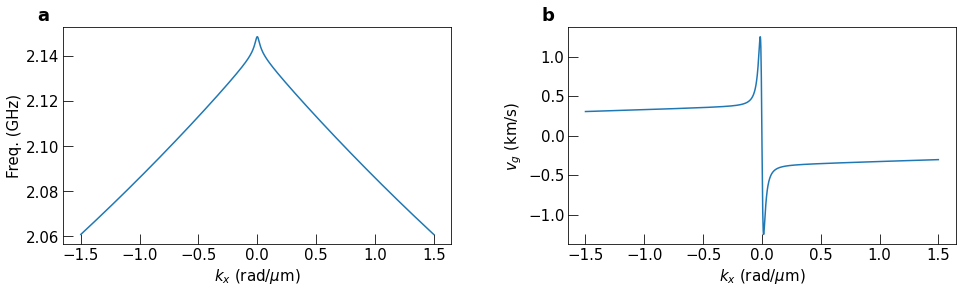

In [24]:
fig,ax=plt.subplots(figsize=(16,4))

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.3, hspace=0.0)

ax1=plt.subplot(gs[0,0]);ax1.set_title(r'$\bf{a}$',x=-0.05,y=1)
ax2=plt.subplot(gs[0,1]);ax2.set_title(r'$\bf{b}$',x=-0.05,y=1)

mu0 = 4*np.pi*10**-7;#H/m
gYIG = 28.0;# gamma over 2pi: in unit of GHz/T from 10.1109/LMAG.2014.2350958 
muMYIG = 0.176;
AYIG = 0.37*10**-11;
dexYIG = 2*AYIG/(muMYIG/mu0)#T m^2 in W.Wes.C:Solid State Phys.8,211 (1975)
thickYIG = 130e-9 #meter;
wYIG=173e-6
lYIG=261e-6

kmax=1.5e6
N1=1500
kx = np.linspace(-kmax, kmax, N1)
dk=kx[1]-kx[0]
muHlist=[28.6]
for i,muH in enumerate(muHlist):
    freq=KS_Freq(gYIG,kx,1*np.pi/wYIG,0,muMYIG,muH/1000,dexYIG,thickYIG,90*np.pi/180)*1e9
    ax1.plot(kx/1e6,freq/1e9,label=f'{muH} mT') # plot dispersion
    vgxlist=np.array(np.gradient(2*np.pi*freq,dk))
    ax2.plot(kx/1e6,vgxlist/1e3,label=f'{muH} mT') # plot vg
[x.set_xlabel('$k_x$ (rad/$\mu$m)') for x in [ax1,ax2]]
ax1.set_ylabel('Freq. (GHz)')
ax2.set_ylabel(r'$v_g$ (km/s)')

# CPW Antenna field

(-2.0, 2.0)

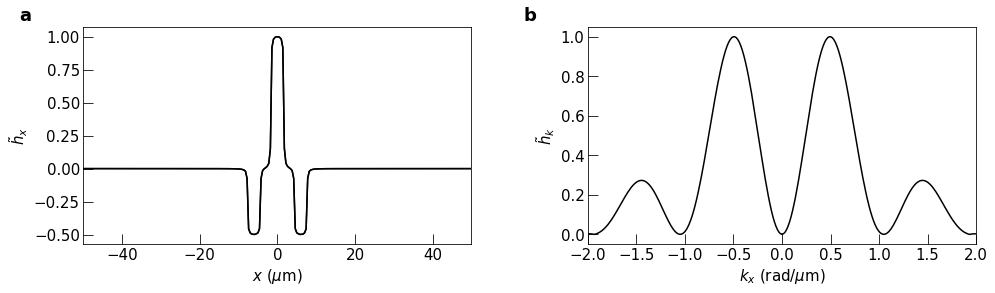

In [41]:
fig,ax=plt.subplots(figsize=(16,4))

gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.3, hspace=0.0)

ax1=plt.subplot(gs[0,0]);ax1.set_title(r'$\bf{a}$',x=-0.15,y=1)
ax2=plt.subplot(gs[0,1]);ax2.set_title(r'$\bf{b}$',x=-0.15,y=1)

#get CPW H field in x-space
Xpts=np.linspace(-200e-6,200e-6,1000);
Ypts=np.array([CPW_Hfield(q,**dict(is_IP=1)) for q in Xpts]);

#get CPW H field in k-space
KXpts,KYpts=FT(Xpts,Ypts)

ax1.plot(Xpts*1e6,Ypts/np.max(Ypts),'k')
ax1.plot(-Xpts*1e6,Ypts/np.max(Ypts),'k')
ax1.set_xlabel('$x~(\mu$m)')
ax1.set_ylabel(r'$\tilde{h}_x$')
ax1.set_xlim(-50,50)

ax2.plot(KXpts/1e6,KYpts/np.max(KYpts),'k')
ax2.plot(-KXpts/1e6,KYpts/np.max(KYpts),'k')
ax2.set_xlabel('$k_x$ (rad/$\mu$m)')
ax2.set_ylabel(r'$\tilde{h}_k$')
ax2.set_xlim(-2,2)

# Magnon-magnon scattering pairs

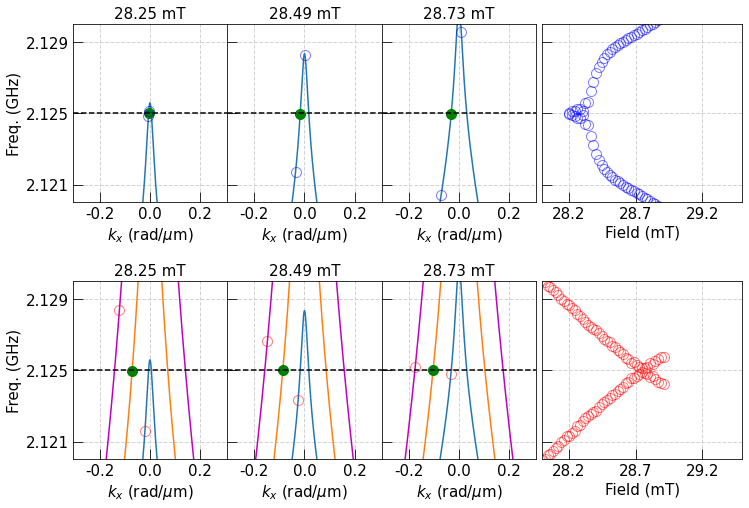

In [55]:
def get_kvsH(muH,nwidth):
    k1list=np.linspace(-max_kx,max_kx,num_kx)
    f1list = KS_Freq(gYIG,k1list,nwidth*np.pi/width,0,muMYIG,muH+muHoff,dexYIG,\
                     thickYIG,90*np.pi/180)\
            +freq_shift+p0*(a0*(muH*1e3)**2+b0*(muH*1e3)+c0)
    k0list,f0list = getintersection(k1list,f1list,f0)
    return muH,k0list[0]
    
def getintersection(x_vals,y1_vals,y2_vals):
    idx = np.argwhere(np.diff(np.sign(y1_vals - y2_vals))).flatten()
    x_inters = x_vals[idx]
    y_inters = y1_vals[idx]
    return x_inters,y_inters

# Power increase of 0.55 mW = field increase of 1 mT
def get_freq(muH,sb,lb,hb,key):
    k1list=np.linspace(-max_kx,max_kx,num_kx)
    f1list = KS_Freq(gYIG,k1list,lb*np.pi/width,0,muMYIG,muH+muHoff,dexYIG,thickYIG,90*np.pi/180)\
            +freq_shift+p0*(a0*(muH*1e3)**2+b0*(muH*1e3)+c0)
    
    if key==0:
        f0list = KS_Freq(gYIG,k1list,sb*np.pi/width,0,muMYIG,muH+muHoff,dexYIG,\
                         thickYIG,90*np.pi/180)\
        +freq_shift+p0*(a0*(muH*1e3)**2+b0*(muH*1e3)+c0)
        k0list,f0list = getintersection(k1list,f0list,f0)
        if len(k0list) == 0:
            return [],[],[], [], [], [], []  
        k2list=2*k0list[1]-k1list
    elif key==1:
        k0list=np.array([0.5e6,-0.5e6])
        f0list=np.array([2.125,2.125])
        k2list=1*k0list[1]-k1list
    elif key==2:
        k0list=np.array([0.0e6,-0.0e6])
        f0list=np.array([2.125,2.125])
        k2list=1*k0list[1]-k1list

    f2list = KS_Freq(gYIG,k2list,hb*np.pi/width,0,muMYIG,muH+muHoff,dexYIG,thickYIG,90*np.pi/180)\
    +freq_shift+p0*(a0*(muH*1e3)**2+b0*(muH*1e3)+c0)
    
    idx = np.argwhere(np.diff(np.sign(2*f0 -(f1list+f2list)))).flatten()
    
    if len(idx) == 0:
        return idx,[],[],[], [], [], []  
    else:
        return idx,k0list/1e6,f0list,k1list[idx]/1e6, f1list[idx], k2list[idx]/1e6, f2list[idx] 

def get_freqlist(n0,n1,n2):
    for i,muH in enumerate(muHlist):
        idx,k0,f0,k1,f1,k2,f2=get_freq(muH,n0,n1,n2,0)
        idxlist.append(idx);k0list.append(k0);f0list.append(f0);k1list.append(k1);
        f1list.append(f1);k2list.append(k2);f2list.append(f2);
    return np.array(idxlist,dtype=object),np.array(k0list,dtype=object),\
np.array(f0list,dtype=object),\
        np.array(k1list,dtype=object),\
            np.array(f1list,dtype=object),np.array(k2list,dtype=object),np.array(f2list,dtype=object)

###### Draw dispersion
def getDisp(ax,muH,num_kx,max_kx,n0,n1,n2):
    kxlist=np.linspace(-max_kx,max_kx,num_kx)
    nlist=[n0,n1,n2]
    if n0==n1:
        ny=n0
        Z0 = KS_Freq(gYIG,kxlist,ny*np.pi/width,0,muMYIG,muH+muHoff,dexYIG,thickYIG,90*np.pi/180)\
        +freq_shift+p0*(a0*(muH*1e3)**2+b0*(muH*1e3)+c0)
        ax.plot(kxlist/1e6,Z0,'-',c= u'#1f77b4',label=r'$n_y=%i$'%ny)
    else:
        clist=[u'#ff7f0e',u'#1f77b4', 'm']
        for i,ny in enumerate(nlist): 
            Z0 = KS_Freq(gYIG,kxlist,ny*np.pi/width,0,muMYIG,muH+muHoff,dexYIG,thickYIG,90*np.pi/180)\
            +freq_shift+p0*(a0*(muH*1e3)**2+b0*(muH*1e3)+c0)
            ax.plot(kxlist/1e6,Z0,'-',c=clist[i],label=r'$n_y=%i$'%ny)
        
########## fig3_intra   
def fig3_draw_pair(ax1a,ax1b,ax1c,color,ind1,ind2,ind3):
#     ind_list=[50,55,60] # for 3.05
    ind_list=[ind1,ind2,ind3] # for 1.05 :59,64,69
    axlist=[ax1a,ax1b,ax1c]
    fp=4.25
    for i,ind in enumerate(ind_list):
        axlist[i].set_title(f'{(muHlist[ind]*1e3+0.5e-2).round(2)} mT',x=0.5,y=1,fontsize=15)
        getDisp(axlist[i],muHlist[ind],num_kx,max_kx,n0,n1,n2)
        j=1 # jth solution 
        if len(k1_010[ind])!=0:
            axlist[i].plot(-k0_010[ind][j],fp-f0_010[ind][j],'go',fillstyle='full',ms=10)
            axlist[i].plot(-2*k0_010[ind][j]+k1_010[ind][j],fp-f1_010[ind][j],'o',alpha=0.5,
                           fillstyle='none',ms=10,color=color)
            axlist[i].plot(-2*k0_010[ind][j]+k2_010[ind][j],fp-f2_010[ind][j],'o',alpha=0.5,
                           fillstyle='none',ms=10,color=color)
        axlist[i].axhline(2.125,c='k',ls='--')
        axlist[i].set_ylim(2.12,2.13)
    ax1b.tick_params(labelleft=0)
    ax1c.tick_params(labelleft=0)
    ax1a.set_ylabel('Freq. (GHz)')

##################### field dependence ######################
def fig3_hdepen(ax2,lab,isCPW1,color,powerind,marker):
    N=100
    x1=[]
    y1=[]
    y2=[]
    for ind in range(N):
        try:
            y2.append(fp-f2_010[ind][j])
            y1.append(fp-f1_010[ind][j])
            x1.append(muHlist[ind]*1e3)
        except IndexError:
            pass  
    if marker=='o':
        ax2.plot(x1,y1,'o',color=color,fillstyle='none',ms=10,alpha=0.5)
        ax2.plot(x1,y2,'o',color=color,fillstyle='none',ms=10,alpha=0.5)
    else:
        ax2.plot(x1,y1,color=color,dashes=[5,5,1],alpha=0.5)
        ax2.plot(x1,y2,color=color,dashes=[5,5,1],alpha=0.5)
    ax2.set_ylim(2.12,2.13)
    ax2.set_xlim(28,30)

######################################### Figure starts ########################################
plt.figure(figsize=(12,8))

gs = gridspec.GridSpec(7,13)
gs.update(wspace=0.0, hspace=0.3)
gs2 = gridspec.GridSpec(7,13)
gs2.update(wspace=0.2, hspace=0.3)

##### These are top panel ####
ax1a=plt.subplot(gs[0:3,0:3]);
ax1b=plt.subplot(gs[0:3,3:6],sharex=ax1a,sharey=ax1a);
ax1c=plt.subplot(gs[0:3,6:9],sharex=ax1a,sharey=ax1a);
ax1d=plt.subplot(gs2[0:3,9:13],sharey=ax1a)   

##### These are bottom panel ####
ax2a=plt.subplot(gs[4:7,0:3],sharex=ax1a,sharey=ax1a);
ax2b=plt.subplot(gs[4:7,3:6],sharex=ax1a,sharey=ax1a);
ax2c=plt.subplot(gs[4:7,6:9],sharex=ax1a,sharey=ax1a);
ax2d=plt.subplot(gs2[4:7,9:13],sharey=ax1a)  

#### Define parameters
mu0 = 4*np.pi*10**-7;#H/m
gYIG = 28.0;# gamma over 2pi: in unit of GHz/T from 10.1109/LMAG.2014.2350958
muMYIG = 0.176*1; #Wettling,M.G.Cottam,and J.
AYIG = 0.37*10**-11;
dexYIG = 2*AYIG/(muMYIG/mu0)#T m^2 in W.Wes.C:Solid State Phys.8,211 (1975)
thickYIG = 130e-9 #meter;
width=173e-6
wYIG=173e-6
lYIG=261e-6

Wcpw=1*3.3e-6
Z0=50
mu0=4*np.pi*1e-7

N=100
muHlist=np.linspace(28e-3,30e-3,N)

f0=2.125
fp=4.25
max_kx=0.35e6
num_kx=10000        
        
a0=-0.00028114 #-0.00028134
b0= 0.00813634 #-3308
c0=5e-4 #1000
p0=1*4.05

muHoff=-0.75e-3 # offset field for field calibration 
freq_shift=0

################## INTRA
j=0
n0=1
n1=1
n2=1

idxlist,k0list,f0list,k1list,f1list,k2list,f2list=[],[],[],[],[],[],[]
idx_010,k0_010,f0_010,k1_010,f1_010,k2_010,f2_010=get_freqlist(**dict(n0=n0,n1=n1,n2=n2))

fig3_draw_pair(ax1a,ax1b,ax1c,'b',12,24,36)
fig3_hdepen(ax1d,'CPW1',1,'b',**dict(powerind=40,marker='o'))

################## INTER
j=1
n0=3
n1=1
n2=5

idxlist,k0list,f0list,k1list,f1list,k2list,f2list=[],[],[],[],[],[],[]
idx_010,k0_010,f0_010,k1_010,f1_010,k2_010,f2_010=get_freqlist(**dict(n0=n0,n1=n1,n2=n2))

fig3_draw_pair(ax2a,ax2b,ax2c,'r',12,24,36)
fig3_hdepen(ax2d,'CPW2',0,'r',**dict(powerind=40,marker='o'))

################## Decoration
ax0a.set_ylabel('$k_x$ (rad/$\mu$m)')
[x.set_xlabel('$k_x$ (rad/$\mu$m)') for x in [ax1a,ax1b,ax1c,ax2a,ax2b,ax2c]]
[x.set_xlabel('Field (mT)') for x in [ax1d,ax2d]]
[x.set_xlim(28,29.5) for x in [ax1d,ax2d]]
[x.set_xticks([28.2,28.7,29.2]) for x in [ax1d,ax2d]]
[x.set_yticks([2.121,2.125,2.129]) for x in [ax1a,ax2a]] 
[x.tick_params(labelleft=0) for x in [ax1d,ax2d]]
[x.grid(1) for x in [ax1a,ax1b,ax1c,ax1d,ax2a,ax2b,ax2c,ax2d]]

def custom_formatter(x, pos):
    return f"{x:.1f}"  # One decimal place for other values
    
for ax in [ax2a, ax2b, ax2c]:
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(custom_formatter)) 